In [1]:
import matplotlib.pyplot as plt
import matplotlib as pmimg
import numpy as np
import skimage
from skimage import color
from skimage import data
from skimage import io
from tqdm import tqdm
import cv2

import os 
dir_path = os.getcwd()

In [2]:
def oneHot(imgTitle):
    animalLabel = imgTitle.split('.')[0][-3:]
    return animalLabel

In [3]:
def createTrainSet():
    trainingSet = []
#     data_dir = '/Users/Jack/Documents/ml/ml_book/DogOrCat/data/practice-train'
    data_dir = '/Users/Jack/Documents/ml/ml_book/DogOrCat/data/train'
    for imgLabel in tqdm(os.listdir(data_dir)):
        animalLabel = oneHot(imgLabel)
        #dog = [1, 0], cat = [0,1]
        oneHotLabel = []
        if animalLabel == 'dog':
            oneHotLabel = [1, 0]
        elif animalLabel == 'cat':
            oneHotLabel = [0, 1]
        else:
            print('nada')
            continue
        imgPath = os.path.join(data_dir, imgLabel)
        imgObj = cv2.imread(imgPath, cv2.IMREAD_GRAYSCALE)
        imgObj = cv2.resize(imgObj, (300, 300))

        trainingSet.append([imgObj, oneHotLabel])
    return trainingSet

train = createTrainSet()

 15%|█▌        | 3795/25001 [00:09<00:50, 416.47it/s]

nada


100%|██████████| 25001/25001 [00:56<00:00, 442.73it/s]


In [4]:
def convolve_2d(img, filter, padding=0, stride=1, depth=1):
    outputDim = len(img[0]) - len(filter[0]) + (2*padding) * stride + 1
    resultArr = np.zeros((depth, outputDim, outputDim), dtype=int)
    filterLength = len(filter)
    
    for zIdx in range(depth):
        for yIdx in range(outputDim):
            for xIdx in range(outputDim):
                window = np.zeros((filterLength, filterLength), dtype=int)

                windowYIdx = 0
                while windowYIdx < len(filter):
                    windowXEnd = xIdx + len(filter)
                    currRow = np.array(img[windowYIdx][xIdx:windowXEnd])
                    window[windowYIdx] = currRow
                    windowYIdx += 1

                filteredWindow = window * filter
                nodeValue = np.average(filteredWindow)
                resultArr[zIdx][yIdx][xIdx] = nodeValue
    
    return resultArr
    #Boom!

side_detector_layer = np.array([
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1]
])


reverse_side_detector_layer = np.array([
    [1, 0, -1],
    [1, 0, -1],
    [1, 0, -1]
])

top_bottom_detector_layer = np.array([
    [1, 0, 1],
    [0, 0, 0],
    [-1, -1, 1]
])

angle_detector_layer = np.array([
    [0, 1, 1],
    [-1, 0, 1],
    [-1, -1, 0]
])


top_detector_layer = np.array([
    [1, 1, 1],
    [-1, -1, -1],
    [-1, -1, -1]
])

right_knight_detector_layer = np.array([
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1],
    [0, 0, 0, 1, 1],
    [0, 0, 0, 1, 1],
    [0, 0, 0, 1, 1]
]);


left_knight_detector_layer = np.array([
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1],
    [1, 1, 0, 0, 0],
    [1, 1, 0, 0, 0],
    [1, 1, 0, 0, 0]
]);

big_edge_detector = np.array([
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 1],
    [1, 1, 1, 1, 0, 0, 0, 0, 1, 1],
    [1, 1, 1, 0, 0, 0, 0, 1, 1, 1],
    [1, 1, 0, 0, 0, 0, 1, 1, 1, 1],
    [1, 0, 0, 0, 0, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
])


reverse_big_edge_detector = np.array([
    [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
    [1, 0, 0, 0, 0, 1, 1, 1, 1, 1],
    [1, 1, 0, 0, 0, 0, 1, 1, 1, 1],
    [1, 1, 1, 0, 0, 0, 0, 1, 1, 1],
    [1, 1, 1, 1, 0, 0, 0, 0, 1, 1],
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 1],
    [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
])

circular_edge_detector = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 1, 1, 1, 1, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 1, 0, 0],
    [0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
    [0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
    [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
])

animal = 24999
imageOne = train[animal][0]

In [5]:
def createConvolutionalLayer(filtersArr, img):
    convFilterArr = []
    for filter in filtersArr:
        convResult = convolve_2d(img, filter, padding=0, stride=1, depth=1)
        convFilterArr.append(convResult)
    return convFilterArr

filters = [
    side_detector_layer,
    reverse_side_detector_layer,
    top_bottom_detector_layer,
    angle_detector_layer,
    top_detector_layer,
    left_knight_detector_layer,
    right_knight_detector_layer,
    big_edge_detector,
    reverse_big_edge_detector,
    circular_edge_detector
]
print(imageOne.shape)
convLayer = createConvolutionalLayer(filters, imageOne)

(300, 300)


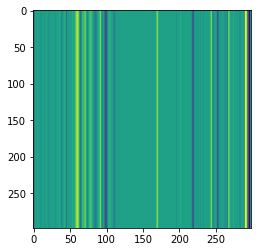

In [6]:
plt.imshow(convLayer[0][0])

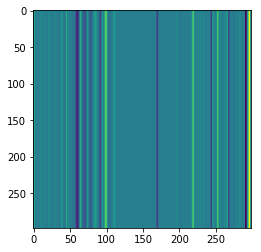

In [7]:
plt.imshow(convLayer[1][0])


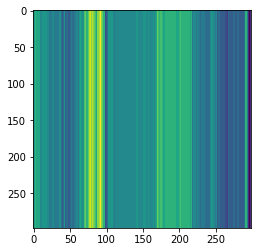

In [8]:
plt.imshow(convLayer[2][0])

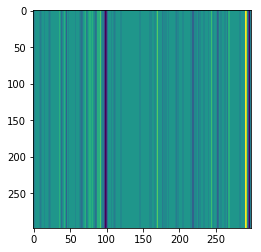

In [9]:
plt.imshow(convLayer[3][0])

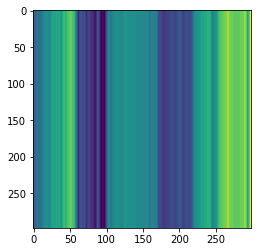

In [10]:
plt.imshow(convLayer[4][0])

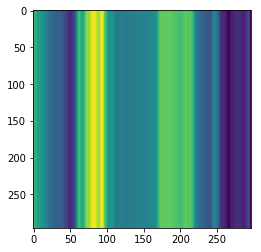

In [11]:
plt.imshow(convLayer[5][0])

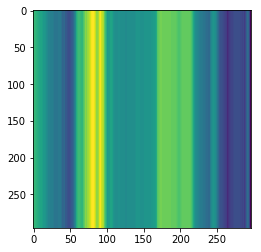

In [12]:
plt.imshow(convLayer[6][0])

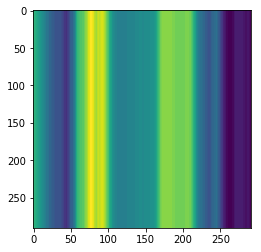

In [13]:
plt.imshow(convLayer[7][0])

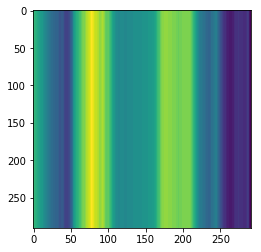

In [14]:
plt.imshow(convLayer[8][0])

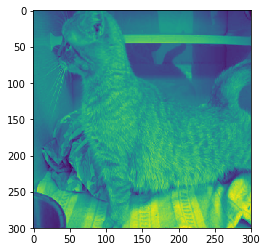

In [15]:
plt.imshow(train[animal][0])